# Trabajo Computacional 3 - Sistemas Complejos 2018

In [1]:
# Importacion de librerias #
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats
import community
import igraph
import pandas as pd
from io import StringIO
import math
import pylab
from scipy import stats

In [2]:
golden_mean = (math.sqrt(5)-1.0)/2.0       # Aesthetic ratio
fig_width = 7+3/8                          # width  in inches
fig_height = fig_width*golden_mean         # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'ps',
          'axes.titlesize': 18,
          'axes.labelsize': 19,
          'axes.linewidth': 0.5, 
          'axes.grid': False,
          'axes.labelweight': 'normal',  
          'font.family': 'serif',
          'font.size': 18.0,
          'font.weight': 'normal',
          'text.color': 'black',
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'legend.fontsize': 18,
          'figure.dpi': 700,
          'figure.figsize': fig_size,
          'savefig.dpi': 700,
         }

pylab.rcParams.update(params)

Cargamos los datos

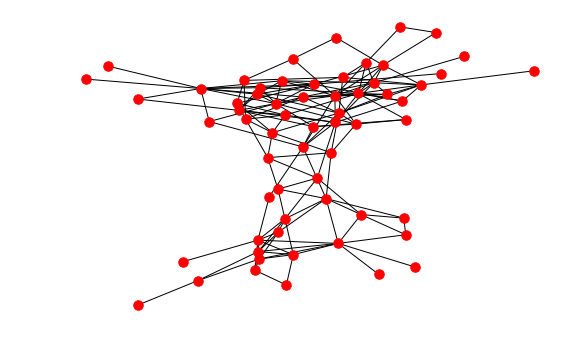

In [3]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=90)
plt.show()

Le agregamos el género a los delfines

In [4]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')
data_gender
colores=[]

# Le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
# Creamos un vector de colores que vincula los generos (mismo orden)     
for node in G.node:
    gen = G.node[node]['genero']
    #print(node,gen)
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')

Graficamos el grafo

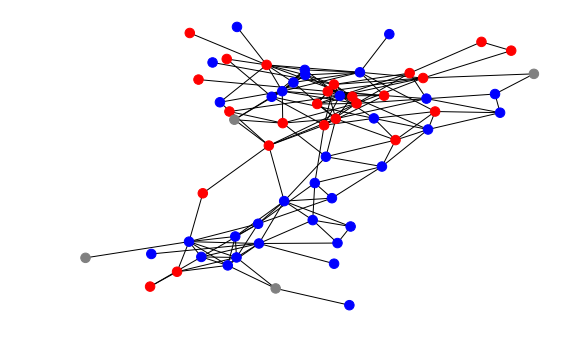

In [5]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_grouping='genero',node_size=90)
plt.show()

# Funcion que calcula particiones

In [6]:
def clusterize(nx_Graph, method="infomap"):
    """
    Calcula el agrupamiento en comunidades de un grafo.
    
    In:
        nx_Graph: grafo de networkx
        method: metodo de clustering, puede ser: "infomap", "fastgreedy", "eigenvector", "louvain", "edge_betweenness","label_prop", "walktrap", ""
        
    Out:
        labels_dict: diccionario de nodo : a label al cluster al que pertenece.
    """
    if method == "edge_betweenness":
        nx_Graph = max(nx.connected_component_subgraphs(nx_Graph), key=len)#se queda con la componente más grande.
        #print("AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.")
    
    isdirected = nx.is_directed(nx_Graph)
    np_adj_list = nx.to_numpy_matrix(nx_Graph)
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
    if method=="label_prop":
        labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
    if method=="eigenvector":
        labels = g.community_leading_eigenvector(weights="weight").membership
    if method=="louvain":
        labels = g.community_multilevel(weights="weight").membership
    if method=="edge_betweenness":
        labels = g.community_edge_betweenness(weights="weight", directed=isdirected).as_clustering().membership
    if method=="walktrap":
        labels = g.community_walktrap(weights="weight").as_clustering().membership
    
    label_dict = {node:label for node,label in zip(nx_Graph.nodes(), labels)}
    return label_dict

In [7]:
colors = ['red','blue','yellow','orange','violet','green','black','grey']

Creamos una función para graficar las redes

In [8]:
def draw_partitions(partition,metodo):
    #drawing
    plt.figure(1,figsize=(10,10)) 
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 160,
                                    node_color = colors[int(count)],alpha=1) 

    nx.draw_networkx_edges(G, pos, alpha=0.1,labels=True)
    plt.axis('off')
    pylab.savefig('partition_%s.eps'%metodo,format='eps', dpi=300, bbox_inches='tight')
    plt.show()

# Clustering por Louvain

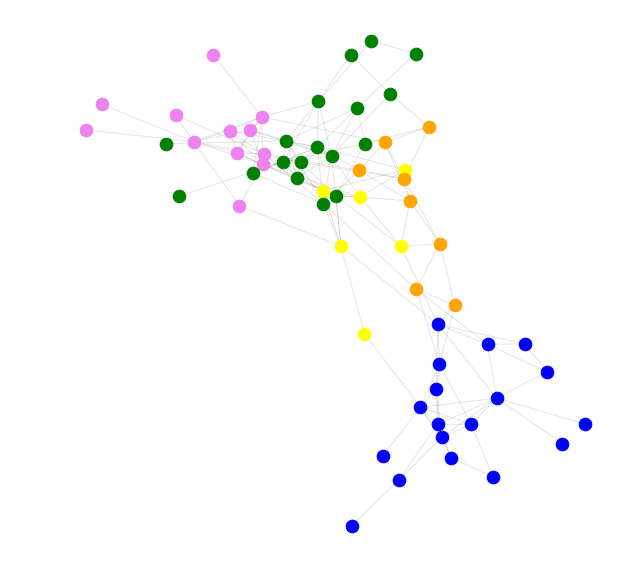

In [9]:
partition_louvain = clusterize(G, method="louvain")
draw_partitions(partition_louvain,"louvain")

# Clustering por Edge Betweenness

In [10]:
partition_edge_betweennes = clusterize(G, method="edge_betweenness")

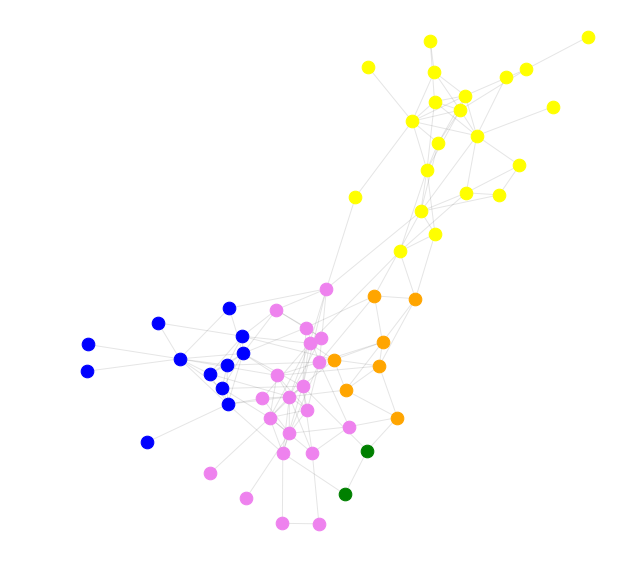

In [11]:
draw_partitions(partition_edge_betweennes,"edge_betweenness")

# Clustering por Fast Greedy

In [12]:
partition_fast_greedy = clusterize(G, method="fastgreedy")

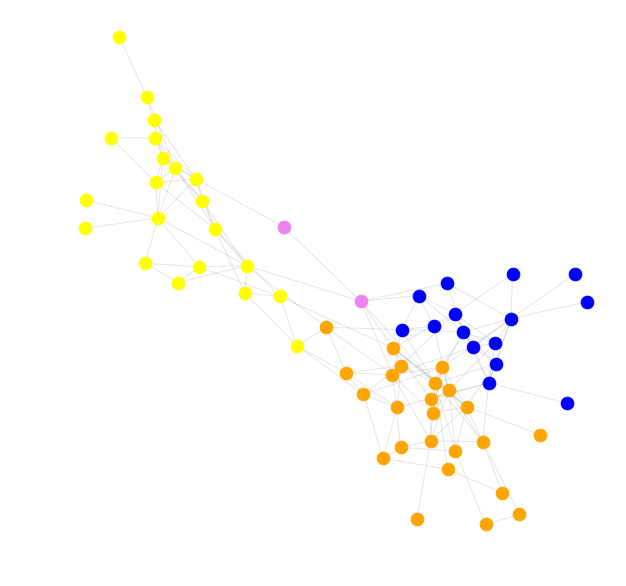

In [13]:
draw_partitions(partition_fast_greedy,"fastgreedy")

# Clustering por Infomap

In [14]:
partition_infomap = clusterize(G, method="infomap")

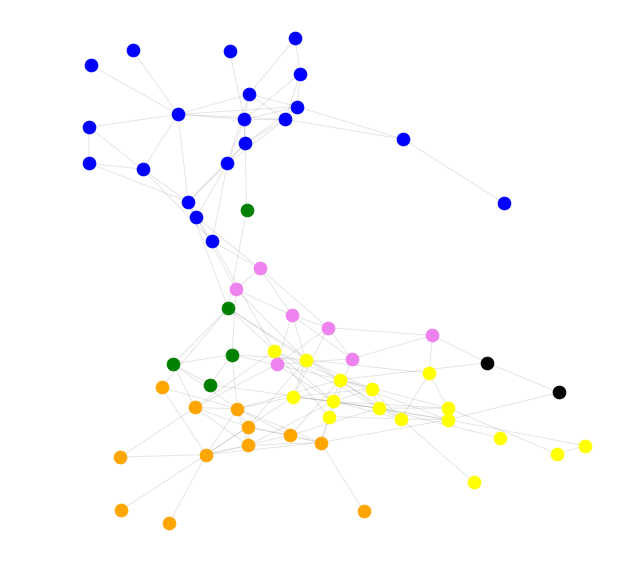

In [15]:
draw_partitions(partition_infomap,"infomap")

Calculamos la cantidad de nodos en cada comunidad

In [16]:
def analisis_comunidades(red,partition):
    l = red.number_of_nodes()
    i = 0
    comunidades = 0
    while i < l:
        nombre_nodo_i = list(red)[i]
        comunidad_nodo_i = partition[nombre_nodo_i]
        if comunidad_nodo_i > comunidades:
            comunidades = comunidad_nodo_i
        i+=1
    comunidades += 1    
    
    i = 0
    nodos_comunidades= np.zeros(comunidades)
    while i < l:
        nombre_nodo_i = list(red)[i]
        comunidad_nodo_i = partition[nombre_nodo_i]
        nodos_comunidades[comunidad_nodo_i] += 1
        i+=1
        
    return (comunidades,nodos_comunidades)

Creamos una función para calcular el coeficiente de Silhouette

In [17]:
def Silhouette_Coefficient(red,partition):
    l = red.number_of_nodes()
    i = 0
    comunidades = analisis_comunidades(red,partition)[0]
    nodos_comunidades = analisis_comunidades(red,partition)[1]
    s = []

    while i < l:
        nombre_nodo_i = list(red)[i]
        camino_comunidad= np.zeros(comunidades)
        comunidad_nodo_i = partition[nombre_nodo_i]
        distancia_i_comunidad = []
        j = 0
        while j < l:
            nombre_nodo_j = list(red)[j]
            comunidad_nodo_j = partition[nombre_nodo_j]
            
            if comunidad_nodo_i == comunidad_nodo_j and i!=j:
                camino = nx.shortest_path_length(red,source=nombre_nodo_i,target=nombre_nodo_j)
                distancia_i_comunidad +=[camino] 
            else:
                camino = nx.shortest_path_length(red,source=nombre_nodo_i,target=nombre_nodo_j)
                camino_comunidad[comunidad_nodo_j] += camino
            j+=1
        
        if distancia_i_comunidad != []:
            distancia_cluster_propio = np.mean(distancia_i_comunidad)  
        else:
            distancia_cluster_propio = 0.0
            
        distancia_clusters_vecinos = camino_comunidad/nodos_comunidades
        
        #print(distancia_clusters_vecinos,comunidades,nodos_comunidades,camino_comunidad)
        if comunidades > 1:
            distancia_cluster_mas_cercano = np.min(distancia_clusters_vecinos[np.nonzero(distancia_clusters_vecinos)])
            numerador = distancia_cluster_mas_cercano - distancia_cluster_propio
            denominador = np.maximum(distancia_cluster_mas_cercano,distancia_cluster_propio)
        
            s+=[numerador/float(denominador)]

        i+=1

    return (s,comunidades)


In [18]:
Silhouette_Coefficient_edge_betweennes = np.max(Silhouette_Coefficient(G,partition_edge_betweennes)[0])

In [19]:
Silhouette_Coefficient_fast_greedy = np.max(Silhouette_Coefficient(G,partition_fast_greedy)[0])

In [20]:
Silhouette_Coefficient_infomap = np.max(Silhouette_Coefficient(G,partition_infomap)[0])

In [21]:
Silhouette_Coefficient_louvain = np.max(Silhouette_Coefficient(G,partition_louvain)[0])

In [22]:
data = pd.DataFrame({" ":["Edge Betweennes",'Fast Greedy','Infomap','Louvain'],
                     "Silhoutte":[round(Silhouette_Coefficient_edge_betweennes,2),round(Silhouette_Coefficient_fast_greedy,2),round(Silhouette_Coefficient_infomap,2),round(Silhouette_Coefficient_louvain,2)],
                     })
data

,,Silhoutte
0,Edge Betweennes,0.63
1,Fast Greedy,0.61
2,Infomap,0.61
3,Louvain,0.55


In [40]:
def Silhoutte_recableado(red):
    it = 100
    i = 0
    silhoutte_recableado_edge_betweennes = []
    silhoutte_recableado_fast_greedy = []
    silhoutte_recableado_infomap = []
    silhoutte_recableado_louvain = []
    copia_red=red.copy()
    
    comp_gigante_original = max(nx.connected_component_subgraphs(copia_red), key=len)
    len_comp_gigante_original = len(comp_gigante_original)
    
    while i < it:
        nueva_red = nx.double_edge_swap(copia_red, nswap=copia_red.number_of_edges(), max_tries=1000)
        
        comp_gigante_recableada = max(nx.connected_component_subgraphs(nueva_red), key=len)
        len_comp_gigante_recableada = len(comp_gigante_recableada)
        
        if len_comp_gigante_original == len_comp_gigante_recableada:
        
            partition_infomap_recableado = clusterize(nueva_red, method="infomap")
            partition_fast_greedy_recableado = clusterize(nueva_red, method="fastgreedy")
            partition_louvain_recableado = clusterize(nueva_red, method="louvain")
            partition_edge_betweennes_recableado = clusterize(nueva_red, method="edge_betweenness")

            resultado_edge_betweennes = Silhouette_Coefficient(copia_red,partition_edge_betweennes_recableado)
            resultado_fast_greedy = Silhouette_Coefficient(copia_red,partition_fast_greedy_recableado)
            resultado_infomap = Silhouette_Coefficient(copia_red,partition_infomap_recableado)
            resultado_louvain = Silhouette_Coefficient(copia_red,partition_louvain_recableado)
            
            comunidades_edge_betweennes = resultado_edge_betweennes[1]
            comunidades_fast_greedy = resultado_fast_greedy[1]
            comunidades_infomap = resultado_infomap[1]
            comunidades_louvain = resultado_louvain[1]
            
            if comunidades_edge_betweennes > 1:
                silhoutte_recableado_edge_betweennes += [np.max(resultado_edge_betweennes[0])]
            if comunidades_fast_greedy > 1:
                silhoutte_recableado_fast_greedy += [np.max(resultado_fast_greedy[0])]
            if comunidades_infomap > 1:
                silhoutte_recableado_infomap += [np.max(resultado_infomap[0])]
            if comunidades_louvain > 1:
                silhoutte_recableado_louvain += [np.max(resultado_louvain[0])]
            
            copia_red=nueva_red

        i+=1
        
    return(silhoutte_recableado_edge_betweennes,silhoutte_recableado_fast_greedy,silhoutte_recableado_infomap,silhoutte_recableado_louvain)

In [41]:
recableado = Silhoutte_recableado(G)

In [42]:
recableado[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## Calculo de modularidad

In [25]:
def modularity(red,partition):
    m = red.number_of_edges()
    A = nx.adjacency_matrix(red)
    v = 0
    sumando=0.0
    l = red.number_of_nodes()
    while v < l:      # Loop de nodo v
        node_v = list(red)[v]
        if node_v in partition:
            partition_v = int(partition[node_v])
            w=0
            while w < l:  # Loop de nodo w
                node_w = list(red)[w]
                if node_w in partition:
                    partition_w = int(partition[node_w])
                    if( partition_v==partition_w and node_v != node_w):
                        kv = int(red.degree()[node_v])
                        kw = int(red.degree()[node_w])
                        sumando+= A[v,w] - (kv*kw)/(2*m)
                w+=1
        v+=1
    modularity = sumando/(2*m)
    return modularity

In [43]:
def random_modularities(red,metodo):
    metodo =  str(metodo)
    copia_red = red.copy()
    partition = clusterize(copia_red, method=metodo)
    modularity_original = modularity(red,partition)
    it_max =100
    it = 0
    array_modularity =[]
    m = red.number_of_edges()
    while it< it_max: 
        red_recableada = nx.double_edge_swap(copia_red, nswap=m, max_tries=1000)
        partition = clusterize(red_recableada, method=metodo)
        if (max(partition.values())>0):
            array_modularity += [modularity(red_recableada,partition)]
        copia_red = red_recableada
        it+=1
        
    ### PLOT ###
    cantidad_bins = 30
    xmin = 0.2
    xmax = 1.0
    plt.axvline(x=modularity_original,color ='r')
    weights = np.ones_like(array_modularity)/float(len(array_modularity))
    #plt.hist(array_modularity,list(np.linspace(xmin,xmax,cantidad_bins)),weights=weights)
    plt.hist(array_modularity)
    plt.xlabel('Modularity')
    plt.ylabel('Frecuency')
    #pylab.xlim(0.2, 1.0)
    #pylab.ylim(0, 0.32)
    pylab.savefig('histo_%s.eps'%metodo,format='eps', dpi=300, bbox_inches='tight')
    plt.show()    

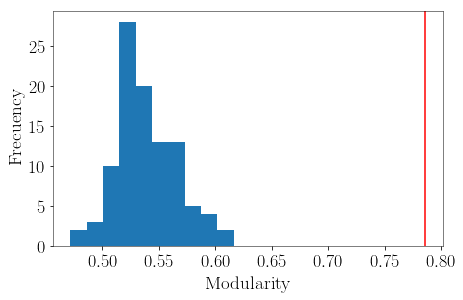

In [44]:
random_modularities(G,"louvain")

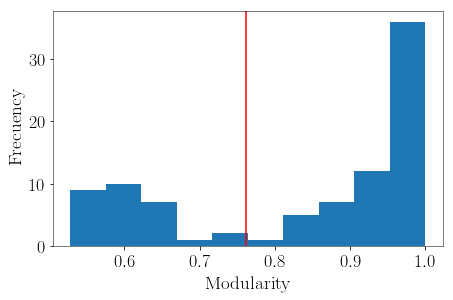

In [45]:
random_modularities(G,"infomap")

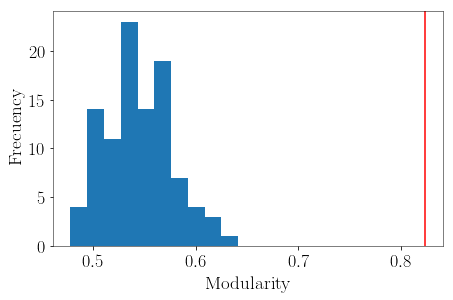

In [46]:
random_modularities(G,"fastgreedy")

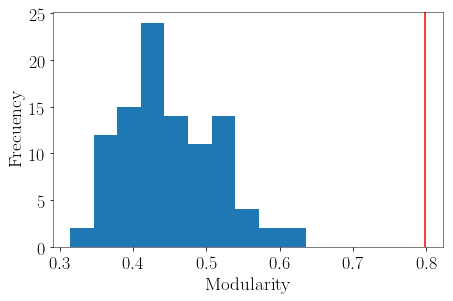

In [47]:
random_modularities(G,"edge_betweenness")